#### Import section

In [2]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind, normaltest, levene, mannwhitneyu
import pingouin as pg
import requests
import urllib
import json

#### Task 1
Retention is one of the most important indicators in a company. Task is to write a function that will count player retention (by days from the player’s registration date). The function must be written in python. During the solution, you can test the operation of the function both on the full dataset and on a part (sample) of data.

#### Data reading and preprocessing

In [3]:
# Create a function for reading files from Yandex Disk.
def link_reader(folder_path, file_path):
    """
    Reads a CSV file from a specified location on Yandex Disk and returns its content as a pandas DataFrame.

    This function constructs a download URL for the specified file located in a Yandex Disk public folder. It then attempts to download the file and load its contents into a pandas DataFrame, assuming the file is in CSV format.

    Parameters:
    - folder_path (str): The public key or URL of the Yandex Disk folder containing the file.
    - file_path (str): The path to the file within the Yandex Disk folder.

    Returns:
    - pandas.DataFrame: The contents of the CSV file as a DataFrame. Returns None if an error occurs during file download or reading.

    Raises:
    - Exception: Describes the error that occurred during the reading of the CSV file if the operation fails.
    """
    folder_url = folder_path
    file_url = file_path
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)
    r = requests.get(url)  # request for the download link
    h = json.loads(r.text)['href']  # parsing the download link
    try:
        df = pd.read_csv(h, sep=';', comment='#', encoding='cp1251')
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        df = None
    return df

In [4]:
# Data reading
registration_df = link_reader('https://disk.yandex.ru/d/BcXB_CuKVX1LRw', 'problem1-reg_data.csv')
login_df = link_reader('https://disk.yandex.ru/d/BcXB_CuKVX1LRw', 'problem1-auth_data.csv')

Due to the fact that the file size is very large, the function may take more than 2 minutes to complete.

In [5]:
registration_df.head(10)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
5,977206495,6
6,984222671,7
7,990407778,8
8,995943765,9
9,1000951674,10


In [6]:
login_df.head(10)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
5,934372615,2
6,934662633,2
7,935002586,2
8,935141232,2
9,935682752,2


In [7]:
# Analyzing data types, we see the need to convert temporary values ​​to the time format from the timestamp
print(registration_df.dtypes)
print(login_df.dtypes)


reg_ts    int64
uid       int64
dtype: object
auth_ts    int64
uid        int64
dtype: object


In [8]:
# Check for empty values
print(registration_df.isna().sum())
print(login_df.isna().sum())

reg_ts    0
uid       0
dtype: int64
auth_ts    0
uid        0
dtype: int64


In [9]:
# Analyzing unique id
print(f'uid registration_df: {registration_df.uid.nunique()}')
print(f'uid login_df: {login_df.uid.nunique()}')

uid registration_df: 1000000
uid login_df: 1000000


**Construction of the retention rate calculation function**

In [10]:
def count_retention_rate(registration_df, login_df, start_date, end_date):
    """
    Calculate the retention rate using cohort analysis.

    This function merges two DataFrames containing user registration and login information, respectively.
    It then filters these merged records based on the provided start and end dates. After establishing
    a time frame, it performs cohort analysis to compute retention rates across different periods.
    
    The function ultimately visualizes these rates as a heatmap, showing how well users retained
    over time after their initial registration.

    Parameters:
    - registration_df (pd.DataFrame): A DataFrame containing at least two columns: 'uid' (user ID) and
      'reg_ts' (registration timestamp).
    - login_df (pd.DataFrame): A DataFrame containing at least two columns: 'uid' (user ID) and
      'auth_ts' (authorization timestamp).
    - start_date (str): The start date for the analysis in "YYYY-MM-DD" format. Only users who registered
      on or after this date will be considered.
    - end_date (str): The end date for the analysis in "YYYY-MM-DD" format. Only logins that occurred on
      or before this date will be considered.

    Returns:
    - pd.DataFrame: A DataFrame where each row represents a cohort (grouped by registration date),
      and each column represents the retention rate for a specific number of days after registration.
      The values are percentages representing the proportion of users who were active on that day
      relative to the initial size of their cohort.

    Note:
    - This function requires pandas (as pd), matplotlib, and seaborn (as sns) libraries.
    - The 'reg_ts' and 'auth_ts' columns in the input DataFrames should be in Unix timestamp format.
    """
    # Merging dataframes with registration and authorization and converting time to standard form
    merged_df = pd.merge(login_df, registration_df, on='uid', how='left')
    merged_df['auth_ts'] = pd.to_datetime(merged_df['auth_ts'], unit='s').dt.date
    merged_df['reg_ts'] = pd.to_datetime(merged_df['reg_ts'], unit='s').dt.date
    
    # Converting string dates to datetime.date objects
    start_date = pd.to_datetime(start_date).date()
    end_date = pd.to_datetime(end_date).date()
    
    # Introducing a time frame restriction
    merged_df = merged_df.query('reg_ts >= @start_date & auth_ts <= @end_date')
    
    # Cohort analysis block
    merged_df['cohort_idx'] = merged_df.apply(lambda x: (x['auth_ts'] - x['reg_ts']).days, axis=1)
    merged_df = merged_df.drop_duplicates(subset=['reg_ts', 'cohort_idx', 'uid'], keep='first')
    merged_df = merged_df.groupby(['reg_ts', 'cohort_idx'], as_index=False)['uid'].nunique()
    pre_report = merged_df.pivot_table(index='reg_ts', columns='cohort_idx', values='uid')
    report = pre_report.divide(pre_report.iloc[:, 0], axis=0).round(3) * 100
    
    plt.figure(figsize=(20, 7))
    plt.title('Heatmap retention rate')
    plt.xlabel('№ of Month')
    plt.ylabel('Cohort')
    sns.heatmap(report, annot=True, cmap='YlGnBu', fmt='g')
    
    return report

    

**Function testing**

In [11]:
# Creating a selective sample.
reg_df = registration_df.head(100000)
log_df = login_df.head(200000)

/var/folders/0n/jvmrq9551fv53nwvmxvjp96c0000gn/T/ipykernel_23364/2238328454.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cohort_idx'] = merged_df.apply(lambda x: (x['auth_ts'] - x['reg_ts']).days, axis=1)


cohort_idx,0,1,2,3,5,6,7,9,11,13,14,16,19
reg_ts,,,,,,,,,,,,,
2009-08-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-02,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-03,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-04,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-05,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-06,100.0,NaN,NaN,50.0,NaN,50.0,NaN,50.0,NaN,NaN,50.0,NaN,50.0
2009-08-07,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-08,100.0,NaN,NaN,NaN,50.0,NaN,NaN,50.0,NaN,NaN,NaN,50.0,NaN
2009-08-09,100.0,NaN,NaN,50.0,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN


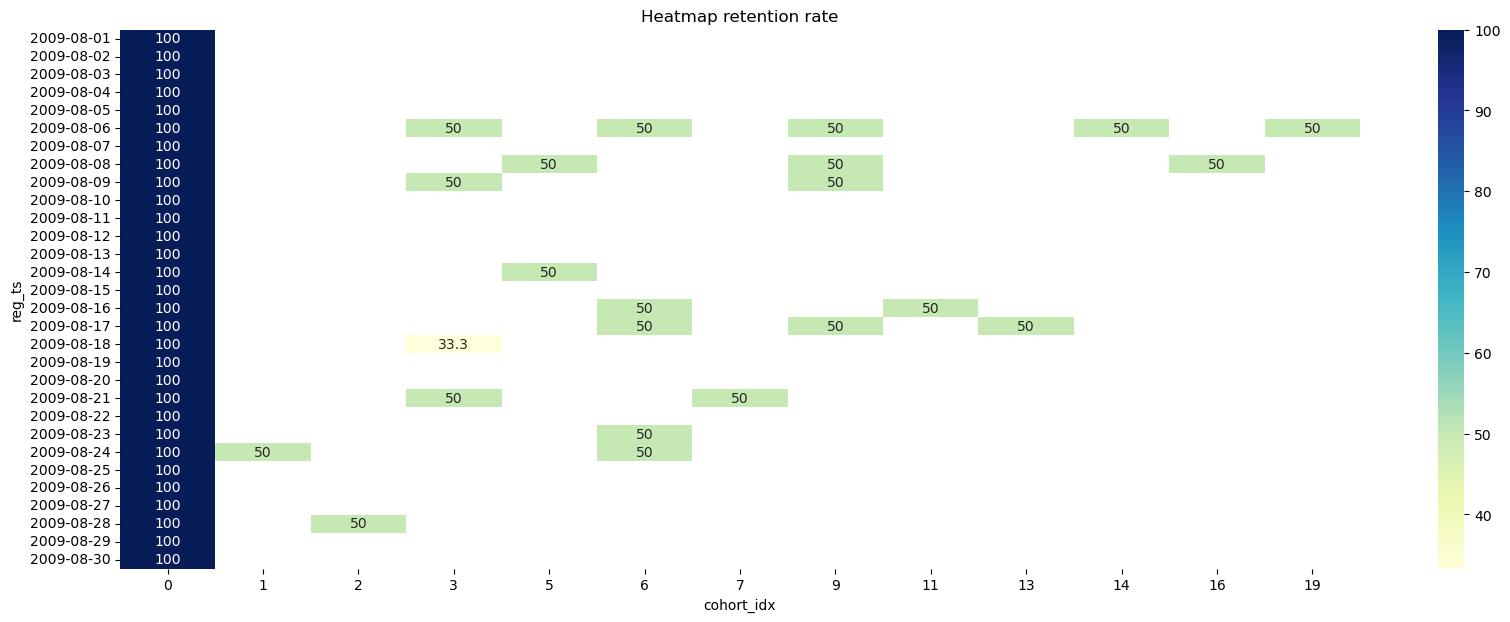

In [12]:
# Testing the function on a selective sample.
count_retention_rate(reg_df, log_df, start_date='2009-08-01', end_date='2009-08-30')

/var/folders/0n/jvmrq9551fv53nwvmxvjp96c0000gn/T/ipykernel_23364/2238328454.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cohort_idx'] = merged_df.apply(lambda x: (x['auth_ts'] - x['reg_ts']).days, axis=1)


cohort_idx,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
reg_ts,,,,,,,,,,,,,,,,,,,,,
2016-04-01,100.0,NaN,6.3,0.9,7.2,3.6,5.4,2.7,4.5,6.3,...,1.8,3.6,2.7,0.9,2.7,2.7,4.5,0.9,0.9,0.9
2016-04-02,100.0,NaN,6.2,7.1,2.7,7.1,10.7,5.4,2.7,9.8,...,2.7,7.1,6.2,3.6,2.7,3.6,2.7,3.6,6.2,NaN
2016-04-03,100.0,0.9,3.6,3.6,4.5,8.0,6.2,2.7,5.4,5.4,...,6.2,1.8,2.7,1.8,2.7,5.4,0.9,1.8,NaN,NaN
2016-04-04,100.0,1.8,7.1,1.8,2.7,7.1,7.1,8.0,3.6,3.6,...,2.7,0.9,3.6,1.8,2.7,1.8,3.6,NaN,NaN,NaN
2016-04-05,100.0,2.7,5.3,7.1,3.5,4.4,6.2,3.5,1.8,5.3,...,1.8,3.5,1.8,5.3,3.5,0.9,NaN,NaN,NaN,NaN
2016-04-06,100.0,NaN,3.6,2.7,2.7,6.2,5.4,6.2,3.6,3.6,...,2.7,1.8,3.6,2.7,1.8,NaN,NaN,NaN,NaN,NaN
2016-04-07,100.0,1.8,3.5,4.4,4.4,4.4,9.7,8.8,3.5,4.4,...,2.7,4.4,2.7,3.5,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-08,100.0,1.8,3.5,4.4,5.3,3.5,7.1,5.3,3.5,7.1,...,6.2,4.4,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-09,100.0,0.9,0.9,2.7,4.4,7.1,4.4,3.5,2.7,6.2,...,3.5,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


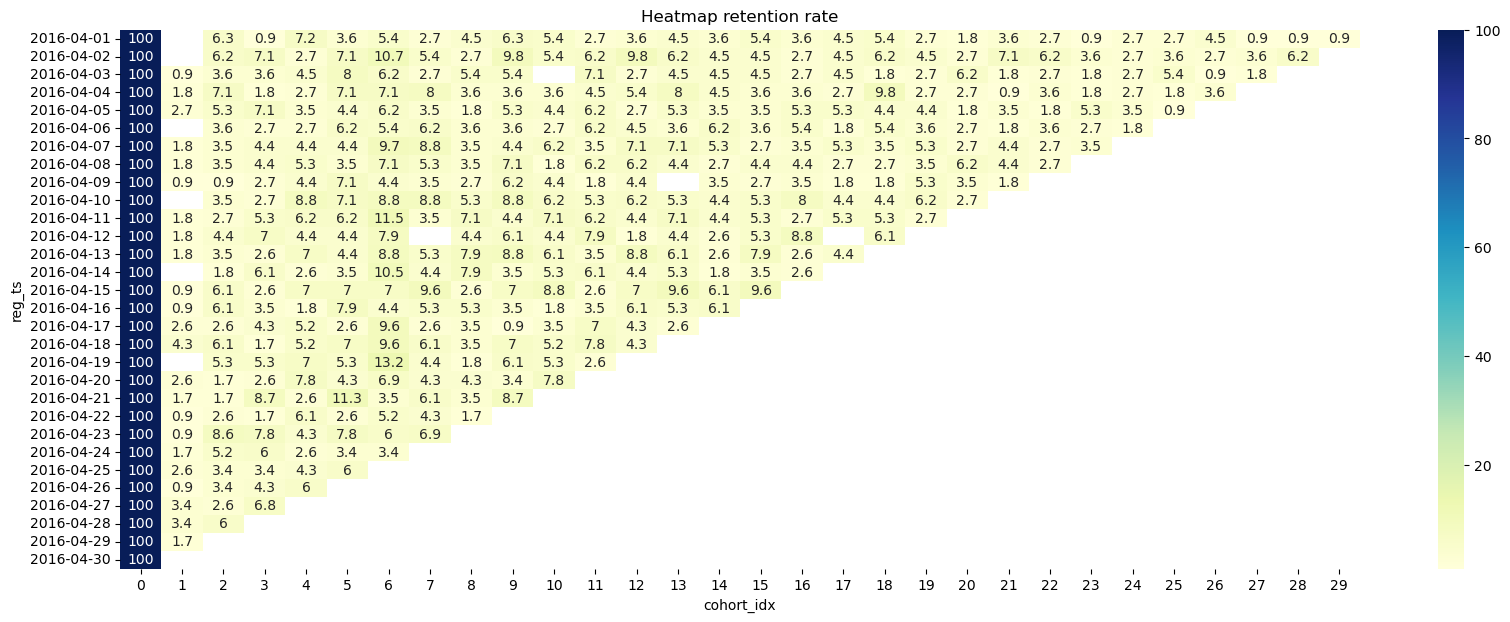

In [13]:
# Function test using complete data, on a sample time period
count_retention_rate(registration_df, login_df, start_date='2016-04-01', end_date='2016-04-30')

! Function processing time can be long

**Next, we will examine the NaN values ​​on the next day after registration.** To do this, we will work with raw data

In [14]:
# Let's reduce the types to the type we need
login_df['auth_ts'] = pd.to_datetime(login_df['auth_ts'], unit='s')
registration_df['reg_ts'] = pd.to_datetime(registration_df['reg_ts'], unit='s')

In [15]:
# df merge
merged_df = pd.merge(login_df, registration_df, on='uid', how='left')

- In the general dataframe, we will filter by the first date after registration; we will also indicate the registration date itself in the filtering, in order to find users who logged in on the date we need from our cohort. For example, consider the 2016-04-01 cohort. Let's use shape to find out how many users performed an action.
  
  
- To find out the number of users in the cohort who came on a certain date, we will do filtering in the df with registration, where we will make a filter with the date we need, including the full day 2016-04-01. Then apply shape to find out the number of users in the cohort

In [16]:
# Analyzing the number of users from the cohort who logged in on the day we need.
logins_length = merged_df.query('auth_ts >= "2016-04-02" & auth_ts < "2016-04-03" & reg_ts >= "2016-04-01" & reg_ts < "2016-04-02"').shape[0]
logins_length


0

In [17]:
# Смотрим на общее число пользователей в необходимой нам когорте.
cohort_length = registration_df.query('reg_ts >= "2016-04-01" & reg_ts < "2016-04-02"').shape[0]
cohort_length

111

- As you can see, the characteristic NaN is the 0 value of users from our cohort who logged in on the day after registration.


- If we change the filtering dates and look at other NaN values ​​the day after registration, we get a similar result.


- At the same time, if we change the login date in filtering to a later one, where we do not have the NaN value in the cohort table, we will get the correct value of users who from our cohort logged in on that day. If we divide this indicator by the number of users from the cohort, then we will get the value of our retention on a specific day.

#### Task 2

There are results of an A/B test in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. At the same time, in the control group, 1928 players out of 202103 turned out to be paying, and in the test group - 1805 out of 202667.

Which set of proposals can be considered the best? What metrics should be analyzed to make the right decision and how?

**Data preprocessing**

In [20]:
# Reading files
df = link_reader('https://disk.yandex.ru/d/BcXB_CuKVX1LRw', 'Проект_1_Задание_2.csv')

In [21]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [22]:
# Check for empty values
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [23]:
# Check data types
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [24]:
# Check unique users
print(f'Total number of observations: {df.shape[0]}')
print(f'Number of unique ids: {df.user_id.nunique()}')

Total number of observations: 404770
Number of unique ids: 404770


In [25]:
# Checking observations by groups
control_group_count = df.query('testgroup == "a"').shape[0]
test_group_count = df.query('testgroup == "b"').shape[0]
print(f'Number of observations in the control group = {control_group_count}')
print(f'Number of observations in the test group = {test_group_count}')

Number of observations in the control group = 202103
Number of observations in the test group = 202667


In [26]:
# Number of paying users
control_payers_count = df.query('testgroup == "a" & revenue > 0').shape[0]
test_payers_count = df.query('testgroup == "b" & revenue > 0').shape[0]
print(f'Number of paying users in the control group = {control_payers_count}')
print(f'Number of paying users in the test group = {test_payers_count}')

Number of paying users in the control group = 1928
Number of paying users in the test group = 1805


**Main Research**

**Choise of statistical method**
First, let's look at conversion rates, we will use the **Chi square** method. We will also determine the threshold at which differences in our data will have statistical significance. Let's set **a = 0.05**

In [27]:
control_conversion_rate = round(control_payers_count / control_group_count, 4)
test_conversion_rate = round(test_payers_count / test_group_count, 4)
print(f'Conversion rate in the control group:{control_conversion_rate}')
print(f'Conversion rate in test group:{test_conversion_rate}')

Conversion rate in the control group:0.0095
Conversion rate in test group:0.0089


**Denote the research hypotheses:**

H(0) Null hypothesis: The proportion of paying users to all users does not depend on the group
H(1) Alternative hypothesis: The proportion of paying users to all users depends on the group

In [28]:
# Function to apply to each row of the dataframe
def spent_money_indicator(row):
    """
    Determine if money was spent based on the revenue value in a DataFrame row.

    This function checks if the 'revenue' column in a given row has a value greater than 0.
    If so, it indicates that money was spent (revenue was generated), and the function returns 1.
    Otherwise, it returns 0, indicating no revenue was generated for that row.

    Parameters:
    - row (pd.Series): A row of a pandas DataFrame. Expected to contain at least a 'revenue' key
      with numeric values.

    Returns:
    - int: Returns 1 if 'revenue' > 0, indicating money was spent. Returns 0 otherwise.

    Example:
    >>> df = pd.DataFrame({'revenue': [10, 0, -5, 30]})
    >>> df['is_paid'] = df.apply(spent_money_indicator, axis=1)
    >>> print(df)
       revenue  is_paid
    0       10        1
    1        0        0
    2       -5        0
    3       30        1

    Note:
    This function is designed to be used with the pandas DataFrame's `apply` method, specifically
    applied across rows (`axis=1`).
    """
    if row['revenue'] > 0:
        return 1
    else:
        return 0

# Create a new column by applying the function to each row
df['is_paid'] = df.apply(spent_money_indicator, axis=1)


In [29]:
# Creating a contingency table.
contingency_table = pd.crosstab(df['testgroup'], df['is_paid'])
print(contingency_table)

is_paid         0     1
testgroup              
a          200175  1928
b          200862  1805


In [30]:
# Conducting a chi-square test
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic value: {chi2}")
print(f"p-value: {p_val}")

Chi-square statistic value: 4.374729521260405
p-value: 0.03647561892312613


The resulting p-value was below the specified threshold a = 0.05
As a result, we can still talk about statistically significant differences in groups.
We have reason to reject the null hypothesis and accept the alternative.
At the same time, conversion rates are higher in the control group (Group a)

**Distribution of paying users**

/var/folders/0n/jvmrq9551fv53nwvmxvjp96c0000gn/T/ipykernel_23364/4121887514.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.query('testgroup == "a" & revenue > 0')['revenue'])


<Axes: xlabel='revenue', ylabel='Density'>

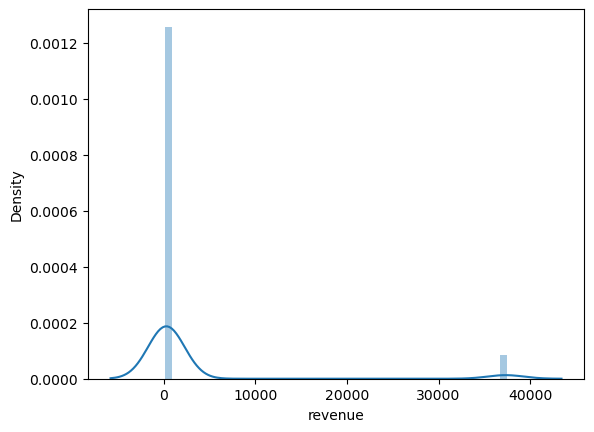

In [31]:
# Distribution of control group of paying users
sns.distplot(df.query('testgroup == "a" & revenue > 0')['revenue'])

/var/folders/0n/jvmrq9551fv53nwvmxvjp96c0000gn/T/ipykernel_23364/2038221423.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.query('testgroup == "b" & revenue > 0')['revenue'])


<Axes: xlabel='revenue', ylabel='Density'>

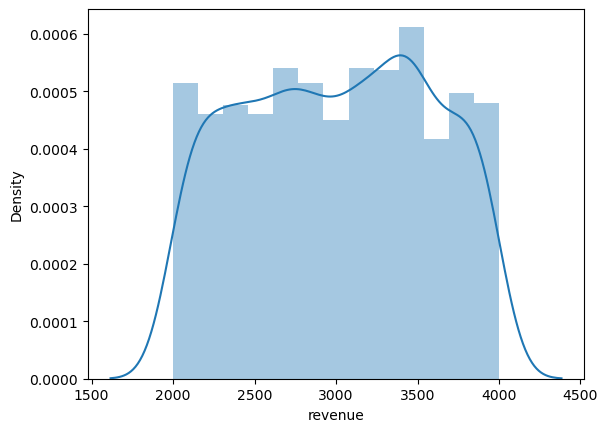

In [32]:
# Distribution of a test group of paying users
sns.distplot(df.query('testgroup == "b" & revenue > 0')['revenue'])

As we see an anamolar distribution in the control group let's try to look in more detail

/var/folders/0n/jvmrq9551fv53nwvmxvjp96c0000gn/T/ipykernel_23364/447031581.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.query('testgroup == "a" & revenue > 30000 & revenue < 50000')['revenue'])


<Axes: xlabel='revenue', ylabel='Density'>

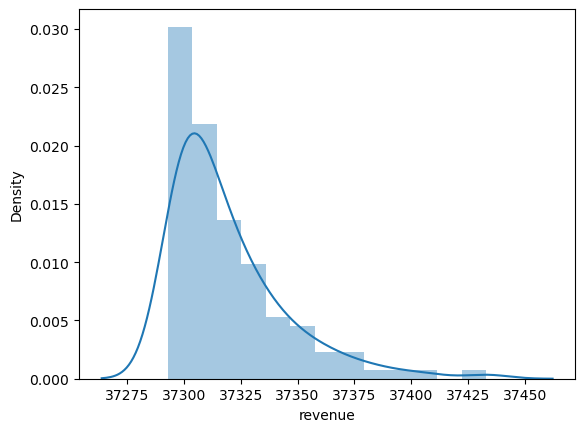

In [33]:
# Distribution of the control group who spent from 30k to 50k
sns.distplot(df.query('testgroup == "a" & revenue > 30000 & revenue < 50000')['revenue'])

/var/folders/0n/jvmrq9551fv53nwvmxvjp96c0000gn/T/ipykernel_23364/798714319.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.query('testgroup == "a" & revenue > 0 & revenue < 10000')['revenue'])


<Axes: xlabel='revenue', ylabel='Density'>

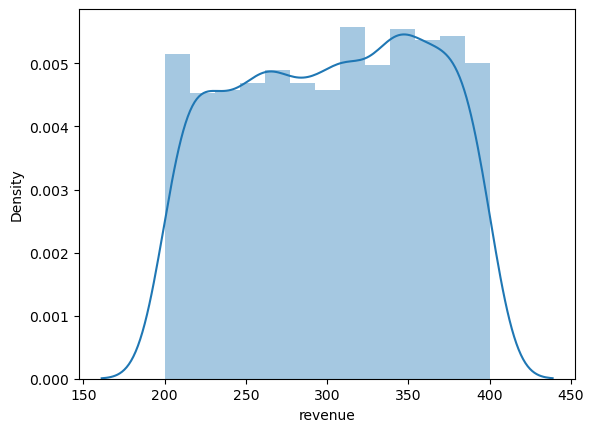

In [34]:
# Distribution of the control group who spent up to 10k
sns.distplot(df.query('testgroup == "a" & revenue > 0 & revenue < 10000')['revenue'])

As we can see, the distribution in the control (a) group is extremely different from the distribution in the test (b). In the test group, almost all buyers spent between 2000 and 4000, while in the control group, most of the buyers spent between 200 and 400, and a small proportion of buyers spent ~37500.

Next, let's try to estimate ARPU using complete data, i.e. both paying and non-paying users

In [35]:
# Creating dataframes with a control and test group for all users
control_group = df.query('testgroup == "a"')
test_group = df.query('testgroup == "b"')


In [36]:
print(f' Number of observations in the control group: {control_group.shape[0]}')
print(f' Number of observations in the test group: {test_group.shape[0]}')

 Number of observations in the control group: 202103
 Number of observations in the test group: 202667


In [37]:
control_avg = round(control_group['revenue'].sum() / control_group['revenue'].count(), 2)
test_avg = round(test_group['revenue'].sum() / test_group['revenue'].count(), 2)
differnece_avg = ((test_avg / control_avg * 100) - 100).round(0)
print(f'ARPU in the control group: {control_avg}')
print(f'ARPU in the test group: {test_avg}')
print(f'ARPU difference: {differnece_avg}%')

ARPU in the control group: 25.41
ARPU in the test group: 26.75
ARPU difference: 5.0%


Let's check the data for normality.
* **Null hypothesis for distributions:** Distributions are **normal**.
* **Alternative hypothesis for distributions:** Distributions are **not normal**.
* We will also determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**

In [38]:
# Carrying out normality tests:
print(normaltest(control_group.revenue))   # for ontrol froup
print(normaltest(test_group.revenue))   # for test group

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


Text(0.5, 1.0, 'Q-Q plot test group')

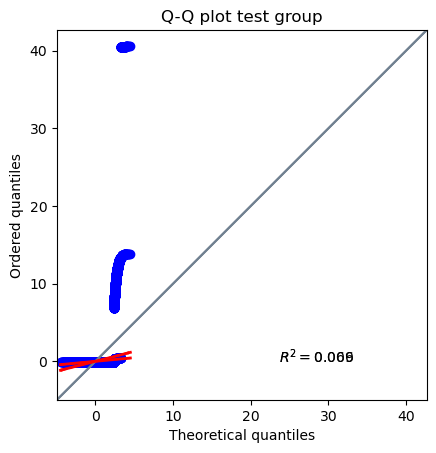

In [39]:
# Visualization of normality distributions
pg.qqplot(control_group.revenue)
plt.title('Q-Q plot control group')

pg.qqplot(test_group.revenue)
plt.title('Q-Q plot test group')

Obviously, both of our distributions are far from normal.

Let's check the data for homogeneity, i.e. for spread of variance using Levene's test.
* **Null hypothesis for distributions:** Variances in both groups are equal.
* **Alternative hypothesis for the distributions:** The variances in both groups are different.
* We will also determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**

In [40]:
levene(control_group.revenue, test_group.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

We cannot reject the null hypothesis, therefore we will assume that the variances in both groups are equal

**Choise of statistical method**
When examining our data for normality and homogeneity, we determined that our distributions were not normal, but found that the variances of our distributions did not differ.
On sufficiently large samples, provided that the variance is homogeneous and the data are independent, it is possible to use the **t-test**, even in the case of a non-normal distribution, this is exactly our case. Therefore, I see it advisable to use t-test.

For the test, set **a = 0.05**

**Denote the research hypotheses for the t-test:**

H(0) Null hypothesis: The average values ​​of money spent by users do not differ in the test and control groups  
H(1) Alternative hypothesis: The average values ​​of money spent by users differ in the test and control groups

In [41]:
# T-test conducting
ttest_ind(control_group.revenue, test_group.revenue)

TtestResult(statistic=-0.6242026493616787, pvalue=0.532494858971837, df=404768.0)

Полученный p-value превышает порог в 0,05 в т-тесте, следовательно, мы не можем отклонить нулевую гипотезу, и можем сказать, ARPU в обоих группах статистически значимо не отличается

**Final Conclusions**

- From the standpoint of ARPU (Average Revenue Per User), we cannot definitively say that one set of offers is better than the other. The 5% difference in ARPU between the groups could be random or caused by other factors not accounted for in this study.

- When considering conversion and the number of paying users, we found that the control group performed slightly better than the test group. The significance was confirmed using the Chi-squared test.

- Looking at the distribution structure of paying users in the control group, we can conclude that we were also able to engage users who paid significantly more than others.

- Based on the results obtained, I would conclude that the offer set of the control group can be considered slightly but better than the set from the test group.

**Task 3**  
In the app, thematic events limited in time are held every month. In these events, players can obtain unique items for their gardens and characters, additional coins, or bonuses. To receive a reward, a player must pass a series of levels within a certain time frame. What metrics can be used to evaluate the outcomes of the last event?

Suppose, in another event, we made the event mechanics more complex so that with each unsuccessful attempt to complete a level, a player would be set back by several levels. Would the set of metrics for evaluating the outcome change? If so, how?

**Response for the standard mechanics:**
* The number of players who participated in the event. This will allow assessing the overall interest in the event.
* Conversion to participants: The proportion of players who started the event after viewing its description. This way, we can understand how attractive the event was to players.
* The average number of levels completed by each event participant. An assessment of the difficulty and interest of the game tasks.
* The proportion of players who successfully completed all levels and received a reward. This will allow assessing the degree of satisfaction of event participants, as well as the level of player engagement in the event.
* The average time spent by players in the event. This will also help understand how long they were engaged in the gameplay.
* The proportion of players who participated in previous thematic events. This way, we can assess the level of loyalty and the repeatability of events.

**Response for the complex mechanics:**
* Player churn: The proportion of players who left the event after several unsuccessful attempts. This is necessary to assess how much the new event mechanics frustrate players and lead to churn.
* The average number of attempts made by each player to pass a level. This will allow us to assess the difficulty of the new mechanics and the level of perseverance of the players.
* The average time spent by each player on a certain level. Here, we also try to understand how difficult or interesting it is for players to cope with the new mechanics.
* The proportion of players who successfully finished the event after the introduction of the new mechanics. This will allow assessing players' adaptation to changes and their level of satisfaction with the new game mechanics.